<a href="https://colab.research.google.com/github/Gdataly/Data-Analysis/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Overview:
--------------
Number of transactions: 55,535
Number of customers: 1,000
Date range: 2023-01-01 to 2023-12-31

Transaction Amount Statistics:
count    55535.00
mean       218.08
std        366.98
min          3.91
25%         44.11
50%         79.38
75%        158.26
max       1975.69
Name: amount, dtype: float64

RFM Metrics Summary:
-------------------
       customer_id  recency  frequency  monetary
count       973.00   973.00     973.00    973.00
mean        500.76    34.89      57.08  12447.19
std         288.91    51.05      46.97  10185.43
min           1.00     0.00       1.00      5.23
25%         251.00     7.00      20.00   3998.83
50%         501.00    18.00      44.00   9862.24
75%         751.00    39.00      81.00  18450.84
max        1000.00   332.00     204.00  46821.37


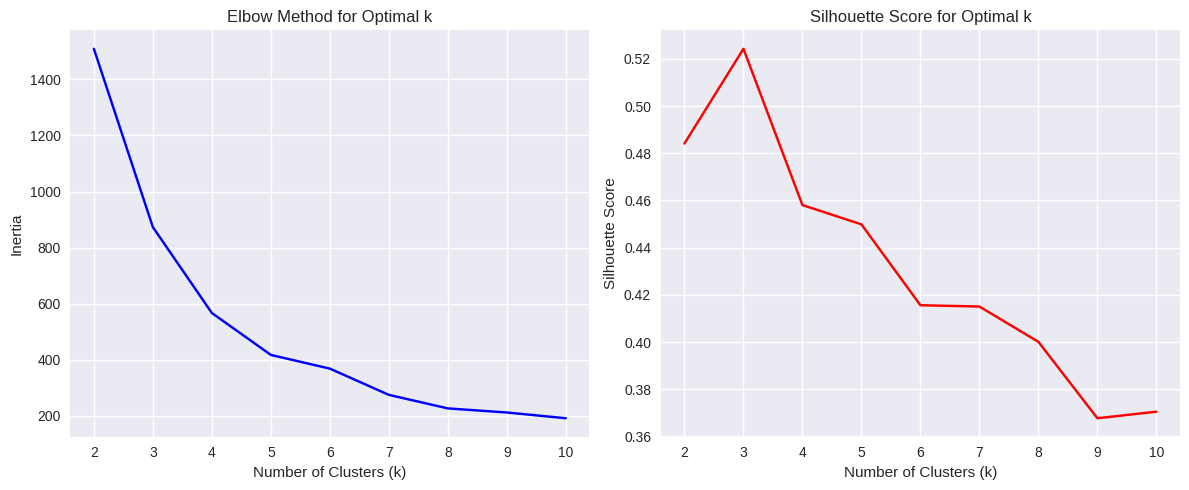


Cluster Analysis:
----------------
         recency  frequency  monetary  customer_id  percentage
cluster                                                       
0          19.30      26.12   5490.72          401       41.21
1           7.73     153.40  32221.91          123       12.64
2         251.88       7.58   1495.24           33        3.39
3          90.01      26.94   5895.63          126       12.95
4          19.33      77.76  17771.88          290       29.80


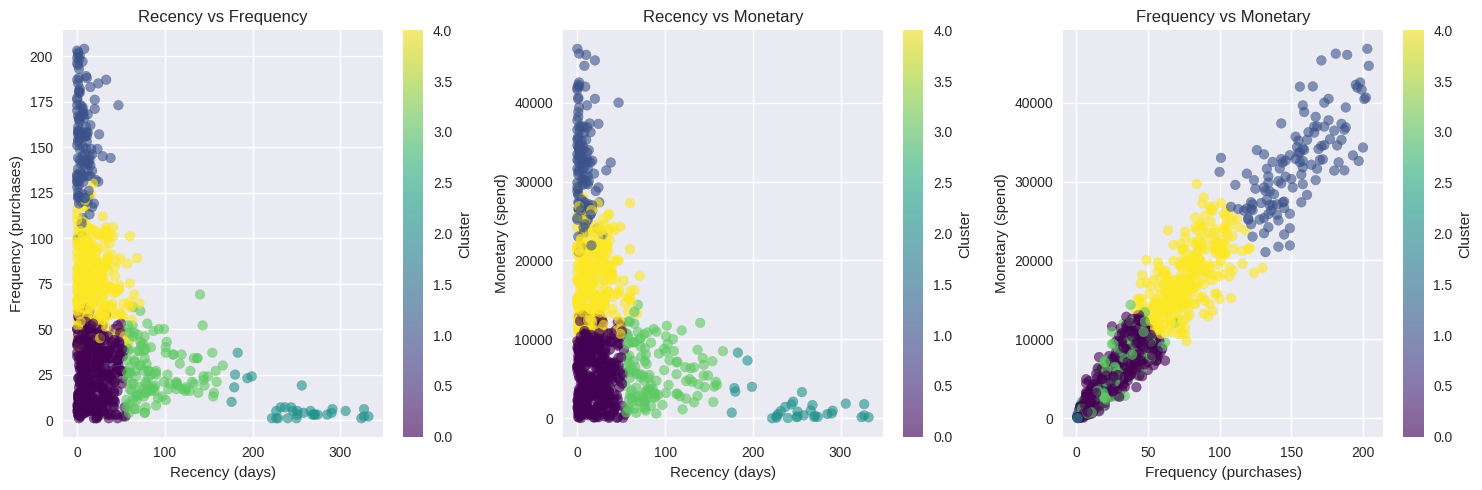


Segment Analysis:
----------------
                    recency          frequency           monetary            \
                       mean min  max      mean min  max      mean       min   
segment_label                                                                 
At Risk              139.62  41  332      9.76   1   19   1944.98      5.23   
High-Value Loyal      12.06   0   60    129.88  82  204  28168.44  18532.44   
Low-Value Irregular   39.65   7  199     26.34   1   62   5211.70     49.98   
Mid-Value Regular     30.36   7  140     61.19  25  124  14428.67  10029.36   
Recent Active          2.93   0    6     38.90   1  108   8312.00     26.60   

                              customer_id             
                          max       count percentage  
segment_label                                         
At Risk               6476.63          87       8.94  
High-Value Loyal     46821.37         211      21.69  
Low-Value Irregular   9862.24         307      31.55  
M

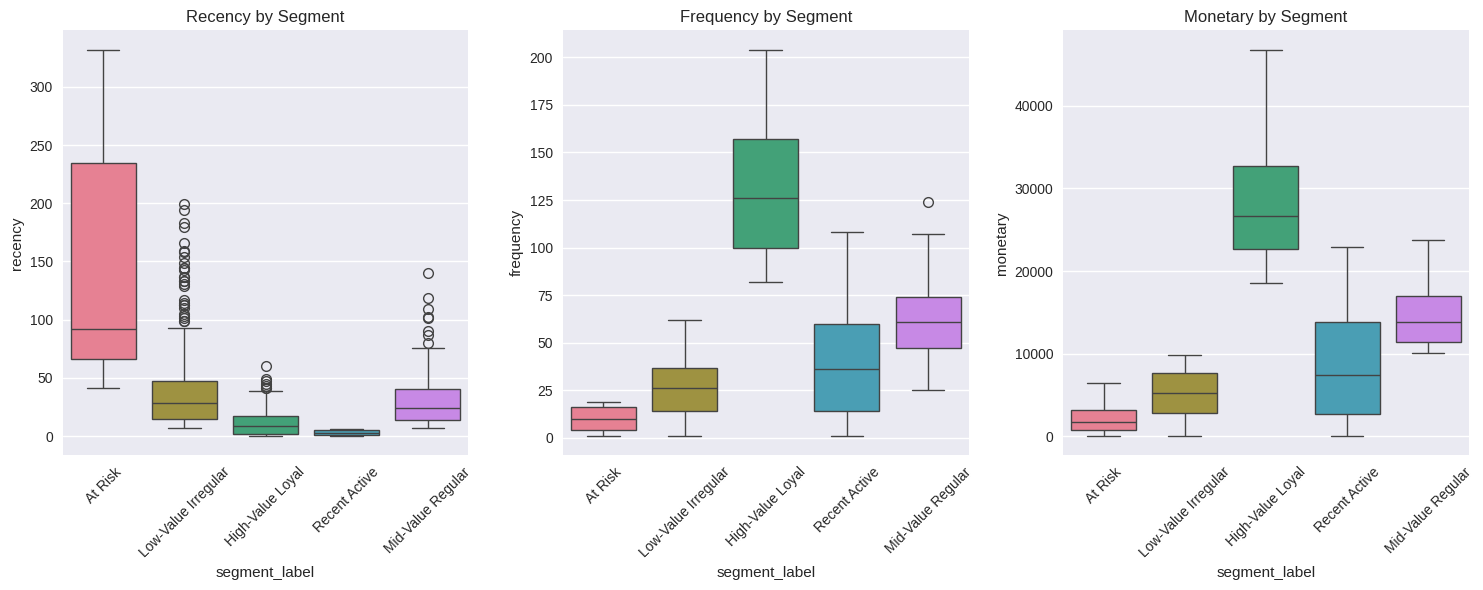


Analysis files saved in: data/processed/


In [ ]:
# Block 1: Setup and Data Loading
#############################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn')
sns.set_palette("husl")

def load_and_prepare_data(transactions_path='/content/data/raw/transactions.csv',
                         customers_path='/content/data/raw/customers.csv'):
    """Load and prepare the transaction and customer data"""
    # Load data
    transactions_df = pd.read_csv(transactions_path)
    customers_df = pd.read_csv(customers_path)

    # Convert date columns
    transactions_df['date'] = pd.to_datetime(transactions_df['date'])
    customers_df['join_date'] = pd.to_datetime(customers_df['join_date'])

    return transactions_df, customers_df

def print_data_overview(transactions_df, customers_df):
    """Print overview of the loaded data"""
    print("Data Overview:")
    print("--------------")
    print(f"Number of transactions: {len(transactions_df):,}")
    print(f"Number of customers: {len(customers_df):,}")
    print(f"Date range: {transactions_df['date'].min().date()} to {transactions_df['date'].max().date()}")

    print("\nTransaction Amount Statistics:")
    print(transactions_df['amount'].describe().round(2))

# Run Block 1
transactions_df, customers_df = load_and_prepare_data()
print_data_overview(transactions_df, customers_df)

# Block 2: RFM Analysis
#############################################
def calculate_rfm(transactions_df):
    """Calculate RFM metrics for each customer"""
    # Calculate analysis date
    analysis_date = transactions_df['date'].max()

    # Calculate RFM metrics
    rfm_data = transactions_df.groupby('customer_id').agg({
        'date': lambda x: (analysis_date - x.max()).days,  # Recency
        'invoice_no': 'count',  # Frequency
        'amount': 'sum'  # Monetary
    }).reset_index()

    # Rename columns
    rfm_data.columns = ['customer_id', 'recency', 'frequency', 'monetary']

    print("\nRFM Metrics Summary:")
    print("-------------------")
    print(rfm_data.describe().round(2))

    return rfm_data

# Run Block 2
rfm_data = calculate_rfm(transactions_df)

# Block 3: Clustering Analysis
#############################################
def perform_clustering_analysis(rfm_data, max_k=10):
    """Perform clustering analysis and determine optimal number of clusters"""
    # Scale the data
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm_data[['recency', 'frequency', 'monetary']])

    # Calculate metrics for different numbers of clusters
    inertias = []
    silhouette_scores = []
    K = range(2, max_k + 1)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(rfm_scaled)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

    # Plot evaluation metrics
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')

    plt.subplot(1, 2, 2)
    plt.plot(K, silhouette_scores, 'rx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Optimal k')

    plt.tight_layout()
    plt.show()

    return rfm_scaled, K, silhouette_scores

# Run Block 3
rfm_scaled, K, silhouette_scores = perform_clustering_analysis(rfm_data)

# Block 4: Customer Segmentation
#############################################
def segment_customers(rfm_data, rfm_scaled, optimal_k=5):
    """Perform customer segmentation using K-means clustering"""
    # Perform clustering
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    rfm_data['cluster'] = kmeans.fit_predict(rfm_scaled)

    # Analyze clusters
    cluster_analysis = rfm_data.groupby('cluster').agg({
        'recency': 'mean',
        'frequency': 'mean',
        'monetary': 'mean',
        'customer_id': 'count'
    }).round(2)

    cluster_analysis['percentage'] = (
        cluster_analysis['customer_id'] / len(rfm_data) * 100
    ).round(2)

    print("\nCluster Analysis:")
    print("----------------")
    print(cluster_analysis)

    return rfm_data, cluster_analysis

# Run Block 4
rfm_data, cluster_analysis = segment_customers(rfm_data, rfm_scaled)

# Block 5: Visualization
#############################################
def visualize_segments(rfm_data):
    """Create visualizations of the customer segments"""
    plt.figure(figsize=(15, 5))

    # Recency vs Frequency
    plt.subplot(1, 3, 1)
    scatter = plt.scatter(rfm_data['recency'], rfm_data['frequency'],
                         c=rfm_data['cluster'], cmap='viridis', alpha=0.6)
    plt.xlabel('Recency (days)')
    plt.ylabel('Frequency (purchases)')
    plt.title('Recency vs Frequency')
    plt.colorbar(scatter, label='Cluster')

    # Recency vs Monetary
    plt.subplot(1, 3, 2)
    scatter = plt.scatter(rfm_data['recency'], rfm_data['monetary'],
                         c=rfm_data['cluster'], cmap='viridis', alpha=0.6)
    plt.xlabel('Recency (days)')
    plt.ylabel('Monetary (spend)')
    plt.title('Recency vs Monetary')
    plt.colorbar(scatter, label='Cluster')

    # Frequency vs Monetary
    plt.subplot(1, 3, 3)
    scatter = plt.scatter(rfm_data['frequency'], rfm_data['monetary'],
                         c=rfm_data['cluster'], cmap='viridis', alpha=0.6)
    plt.xlabel('Frequency (purchases)')
    plt.ylabel('Monetary (spend)')
    plt.title('Frequency vs Monetary')
    plt.colorbar(scatter, label='Cluster')

    plt.tight_layout()
    plt.show()

# Run Block 5
visualize_segments(rfm_data)

# Block 6: Segment Labeling and Analysis
#############################################
def label_and_analyze_segments(rfm_data):
    """Label segments and provide detailed analysis"""
    # Define labeling function
    def assign_segment_label(row):
        if row['frequency'] > np.percentile(rfm_data['frequency'], 75) and \
           row['monetary'] > np.percentile(rfm_data['monetary'], 75):
            return 'High-Value Loyal'
        elif row['recency'] < np.percentile(rfm_data['recency'], 25):
            return 'Recent Active'
        elif row['frequency'] < np.percentile(rfm_data['frequency'], 25) and \
             row['recency'] > np.percentile(rfm_data['recency'], 75):
            return 'At Risk'
        elif row['monetary'] > np.percentile(rfm_data['monetary'], 50):
            return 'Mid-Value Regular'
        else:
            return 'Low-Value Irregular'

    # Apply labels
    rfm_data['segment_label'] = rfm_data.apply(assign_segment_label, axis=1)

    # Create segment summary
    segment_summary = rfm_data.groupby('segment_label').agg({
        'recency': ['mean', 'min', 'max'],
        'frequency': ['mean', 'min', 'max'],
        'monetary': ['mean', 'min', 'max'],
        'customer_id': 'count'
    }).round(2)

    segment_summary[('customer_id', 'percentage')] = \
        (segment_summary[('customer_id', 'count')] / len(rfm_data) * 100).round(2)

    print("\nSegment Analysis:")
    print("----------------")
    print(segment_summary)

    return rfm_data, segment_summary

# Run Block 6
rfm_data, segment_summary = label_and_analyze_segments(rfm_data)

# Block 7: Detailed Segment Profiling
#############################################
def create_segment_profiles(rfm_data):
    """Create detailed profiles for each segment"""
    print("\nDetailed Segment Profiles:")
    print("-----------------------")
    for segment in rfm_data['segment_label'].unique():
        segment_data = rfm_data[rfm_data['segment_label'] == segment]
        print(f"\n{segment}:")
        print(f"Number of customers: {len(segment_data):,} ({len(segment_data)/len(rfm_data)*100:.1f}%)")
        print(f"Average recency: {segment_data['recency'].mean():.1f} days")
        print(f"Average frequency: {segment_data['frequency'].mean():.1f} purchases")
        print(f"Average monetary value: ${segment_data['monetary'].mean():.2f}")

    # Visualize segment characteristics
    plt.figure(figsize=(15, 6))
    segment_colors = sns.color_palette("husl", n_colors=len(rfm_data['segment_label'].unique()))

    metrics = ['recency', 'frequency', 'monetary']
    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, 3, i)
        sns.boxplot(data=rfm_data, x='segment_label', y=metric, palette=segment_colors)
        plt.xticks(rotation=45)
        plt.title(f'{metric.capitalize()} by Segment')

    plt.tight_layout()
    plt.show()

# Run Block 7
create_segment_profiles(rfm_data)

# Block 8: Save Results
#############################################
def save_results(rfm_data, cluster_analysis, segment_summary, output_dir='data/processed/'):
    """Save analysis results to files"""
    os.makedirs(output_dir, exist_ok=True)

    rfm_data.to_csv(f'{output_dir}customer_segments.csv', index=False)
    cluster_analysis.to_csv(f'{output_dir}cluster_analysis.csv')
    segment_summary.to_csv(f'{output_dir}segment_insights.csv')

    print(f"\nAnalysis files saved in: {output_dir}")

# Run Block 8
save_results(rfm_data, cluster_analysis, segment_summary)